<small><font color=gray>Notebook authors: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a>, Kiryll Bykov, Alexey Boldyrev ©2025 onwards</font></small><hr style="margin:0;background-color:silver">

**[<font size=6>📈Crypto</font>](https://www.kaggle.com/t/6b709a22e09744c580e9f5d23ba90401)**. [**Instructions**](https://colab.research.google.com/drive/1owkYjuRGkx050LQnM3b3yTzd0Dr2XbeV) for running Colabs.

<small>**CONSENT.** <mark>[ X ]</mark> We consent to sharing our Colab (after the assignment ends) with other students/instructors for educational purposes.

In [ ]:
from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if kaggle.json is stored in Google Drive

Mounted at /content/drive


In [ ]:
%%capture
pip install -U kaggle  # upgrade kaggle package (to avoid a warning)

In [ ]:
!mkdir -p ~/.kaggle                               # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
# !cp kaggle.json ~/.kaggle/kaggle.json           # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                  # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v 1-apr-25-hse-crypto # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download                     # download competition dataset as a zip file
!unzip -o *.zip                                   # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show           # print public leaderboard

- competition is now set to: 1-apr-25-hse-crypto
Using competition: 1-apr-25-hse-crypto
Archive:  1-apr-25-hse-crypto.zip
  inflating: sampleSubmission.csv    
  inflating: tXY.csv                 
Using competition: 1-apr-25-hse-crypto
  teamId  teamName               submissionDate              score    
--------  ---------------------  --------------------------  -------  
13588645  Z                      2025-04-10 19:29:27.796000  0.62696  
13606285  E                      2025-04-11 11:15:19.306000  0.61008  
13588121  A                      2025-04-11 07:02:31.473000  0.59501  
13608137  D                      2025-04-11 10:36:57.763000  0.58182  
13616218  M                      2025-04-11 06:14:10.850000  0.55565  
13597158  Q                      2025-04-11 11:25:19.656000  0.48917  
13608979  AM                     2025-04-04 11:20:36.466000  0.47269  
13638438  📈 AI                   2025-04-09 19:55:52.650000  0.46910  
13604299  S                      2025-04-11 10:32:03.

See [more](https://nvidia.custhelp.com/app/answers/detail/a_id/3751/~/useful-nvidia-smi-queries) about NVIDIA GPU stats. Test your code in (free) Colab. It uses Tesla T4 or Tesla K80 GPU.

In [ ]:
!nvidia-smi --query-gpu=gpu_name,memory.total,memory.free,memory.used --format=csv

name, memory.total [MiB], memory.free [MiB], memory.used [MiB]
Tesla T4, 15360 MiB, 15095 MiB, 0 MiB


In [ ]:
%%time
%%capture
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, os
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60*5): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=5, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)

CPU times: user 313 ms, sys: 1.61 ms, total: 315 ms
Wall time: 314 ms


Your training data are 7 descriptive features for past 500K observations. See helpful [Tutorial to the G-Research Crypto Competition](https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition).

In [ ]:
tXY = pd.read_csv('tXY.csv', index_col='id'); tXY

,Count,Open,High,Low,Close,Volume,VWAP
id,,,,,,,
0,64,0.20,0.20,0.20,0.20,447,0.20
1,72,0.20,0.20,0.20,0.20,592,0.20
...,...,...,...,...,...,...,...
499998,1636,1.15,1.16,1.15,1.15,2615,1.15
499999,3228,1.13,1.14,1.12,1.13,3354,1.13


Your task is to forecast the closing price for all future time steps (index IDs below).

In [ ]:
pY = pd.read_csv('sampleSubmission.csv', index_col='id'); pY.T

id,500000,500001,500002,500003,500004,500005,500006,500007,500008,500009,...,524421,524422,524423,524424,524425,524426,524427,524428,524429,524430
Close,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
tmr = Timer() # runtime limit (in seconds). Add all of your code after the timer

⏳ started. You have 300 sec. Good luck!


<font size=5>⏳</font> <strong><font color=orange size=5>Your Code, Documentation, Ideas and Timer Start Here...</font></strong>


**TODO. Explain your preprocessing:** i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc.

**TODO. Explain your modeling approach:** ideas you tried and why you thought they would be helpful. Takeaway: how these decisions guided you in modeling.

### Preprocessing

Our initial challenge was to transform raw crypto data into a form that’s both understandable and useful for analysis. We kicked off with an exploratory analysis to get a feel for the data, which set the stage for our more detailed preprocessing steps. Here’s a breakdown of what we did:

1. Data Cleaning and Normalization:  
   We spent a considerable amount of time dealing with missing data and outliers—common issues in crypto datasets. Normalization was crucial, since the wide range of values across different features could otherwise skew our models.

2. Feature Engineering:  
   We believe the magic often happens when you create the right features. In this project, we engineered several new variables that capture important aspects of the crypto market. For instance, we calculated technical indicators such as moving averages, the relative strength index (RSI), and volatility measures.

3. Subsampling:  
   With the massive volume of crypto data at hand, subsampling became an essential step. We crafted a strategy to sample data from different time periods and under varying market conditions. This balanced approach helped us avoid overfitting and ensured that our models were exposed to a wide range of scenarios.

4. Clustering and Dimensionality Reduction:  
   To manage the high dimensionality of our data and to unearth underlying patterns, we applied clustering techniques. This helped us identify groups of similar assets and behaviors, simplifying the complexity inherent in the dataset. Moreover, by implementing Principal Component Analysis (PCA), we reduced the number of correlated features into a smaller set of representative components, significantly boosting our computational efficiency without losing too much informational content.

### Modeling Approach

Once we had our data nicely preprocessed, our next focus was on building models that could accurately capture the dynamics of the crypto market. Here’s how we approached this phase:

1. Baseline Models and Initial Experiments:  
   We started by testing some straightforward models like linear regression and decision trees. These models were a good starting point—they allowed us to get a quick sense of which features were most influential and to establish a performance baseline.

2. Exploring Nonlinear Models and Ensembles:  
   Recognizing that crypto markets are highly nonlinear and volatile, we soon moved to more complex models. We experimented with ensemble methods such as Random Forests and Gradient Boosting Machines (GBM). These models helped us capture the non-linear interactions in the data more effectively. We also explored Support Vector Machines (SVMs) with kernel methods to further address non-linear relationships within our feature space.

3. Iterative Testing and Evaluation:  
   Every model was subjected to rigorous evaluation using cross-validation. We used metrics like mean squared error for regression tasks and accuracy or F1-scores. This iterative testing process allowed us to tweak the models—adjusting hyperparameters and refining our features—until we found a good balance between model complexity and performance.

4. Reflecting on Our Approach:  
   One of the most valuable lessons we learned was the impact of our preprocessing efforts on the overall model performance. The thoughtful creation of features and the reduction of dimensionality not only simplified the modeling process but also enhanced accuracy. The initial experiments with simpler models helped guide our transition to more sophisticated methods, affirming that sometimes the basics are the building blocks for tackling more complex dynamics.

This is your baseline DNN model. Remember to [seed all your experiments](https://pytorch.org/docs/stable/notes/randomness.html#reproducibility) for reproducibility.

taX.shape=(K,Nx,p)=(50, 20000, 7); taY=(K,Ny)=(50, 24431)


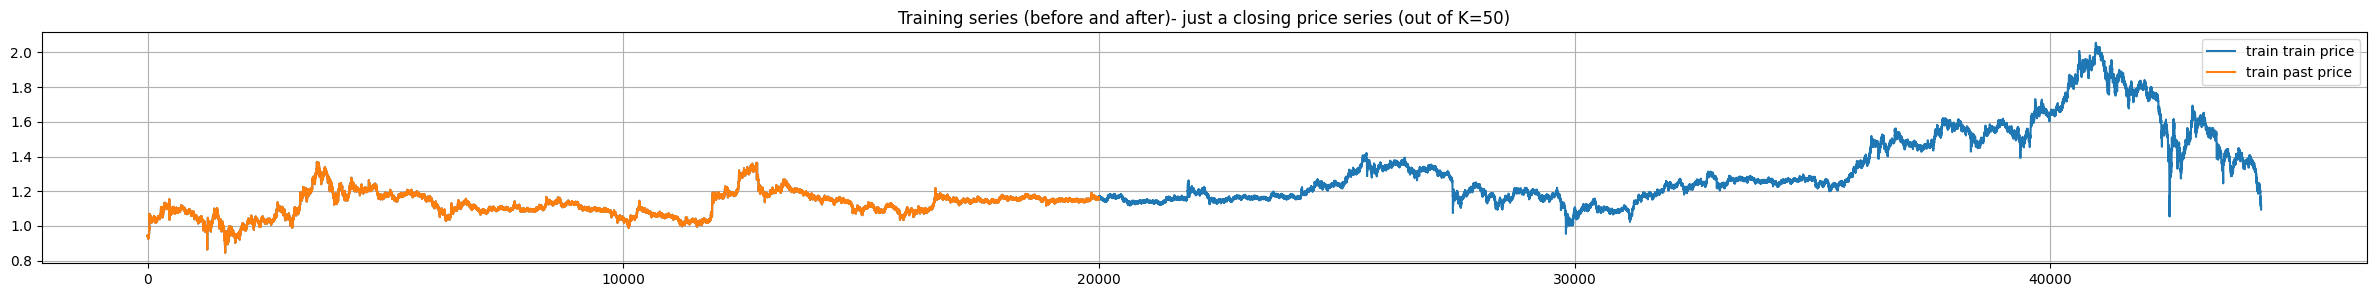

In [ ]:
K, (N, p), Nx, Ny = 50, tXY.shape, 20000, len(pY)  # samples, dataset dim, train set size, forecast set size
LtX, LtY = [], []
for i in range(N-Ny-K, N-Ny):                     # populate K samples with past X series and future Y series
  LtX.append(tXY.iloc[(i-Nx):i, :].values)        # X: historical 7Dim observations for Nx steps behind
  LtY.append(tXY.loc[i:(i+Ny-1),'Close'].values)  # Y: future closing prices for Ny steps ahead
taX, taY = np.array(LtX), np.array(LtY)           # training arrays past input X and future output Y
print(f'taX.shape=(K,Nx,p)={taX.shape}; taY=(K,Ny)={taY.shape}')  # convert to 3-tensors

df = pd.DataFrame(np.r_[taX[0,:,4], taY[0,:]], columns=['train train price'])
ax = df.plot(figsize=(30,3), title=f'Training series (before and after)- just a closing price series (out of K={K})');
pd.DataFrame(taX[0,:,4], columns=['train past price']).plot(grid=True, ax=ax);

Build an LSTM model with two hidden layers. It splits $K$ samples into batches with 7D series $X_{N_x\times p}$ as input and 1D series $Y_{N_y\times 1}$ as output.


The plot below: the model memorized the prices from recent history (plus some local noise). Still you can use these predictions to visually (i.e. qualitatively) determine whether predictions are meaningful (i.e. have price-like shape) or just noise.

<ipython-input-37-2828b469ca1f>:105: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


MemoryEfficientLSTM(
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24431, bias=True)
  )
)

<ipython-input-37-2828b469ca1f>:117: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


MemoryEfficientLSTM(
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24431, bias=True)
  )
)

MemoryEfficientLSTM(
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24431, bias=True)
  )
)

MemoryEfficientLSTM(
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24431, bias=True)
  )
)

MemoryEfficientLSTM(
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24431, bias=True)
  )
)

MemoryEfficientLSTM(
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24431, bias=True)
  )
)

MemoryEfficientLSTM(
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24431, bias=True)
  )
)

MemoryEfficientLSTM(
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24431, bias=True)
  )
)

MemoryEfficientLSTM(
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24431, bias=True)
  )
)

MemoryEfficientLSTM(
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24431, bias=True)
  )
)

MemoryEfficientLSTM(
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24431, bias=True)
  )
)

MemoryEfficientLSTM(
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24431, bias=True)
  )
)

MemoryEfficientLSTM(
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24431, bias=True)
  )
)

MemoryEfficientLSTM(
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24431, bias=True)
  )
)

MemoryEfficientLSTM(
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24431, bias=True)
  )
)

MemoryEfficientLSTM(
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24431, bias=True)
  )
)

MemoryEfficientLSTM(
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24431, bias=True)
  )
)

MemoryEfficientLSTM(
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24431, bias=True)
  )
)

MemoryEfficientLSTM(
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24431, bias=True)
  )
)

MemoryEfficientLSTM(
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24431, bias=True)
  )
)

MemoryEfficientLSTM(
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24431, bias=True)
  )
)

MemoryEfficientLSTM(
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24431, bias=True)
  )
)

MemoryEfficientLSTM(
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24431, bias=True)
  )
)

MemoryEfficientLSTM(
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24431, bias=True)
  )
)

MemoryEfficientLSTM(
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24431, bias=True)
  )
)

MemoryEfficientLSTM(
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24431, bias=True)
  )
)

MemoryEfficientLSTM(
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24431, bias=True)
  )
)

MemoryEfficientLSTM(
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24431, bias=True)
  )
)

MemoryEfficientLSTM(
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24431, bias=True)
  )
)

MemoryEfficientLSTM(
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24431, bias=True)
  )
)

MemoryEfficientLSTM(
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24431, bias=True)
  )
)

<ipython-input-37-2828b469ca1f>:129: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


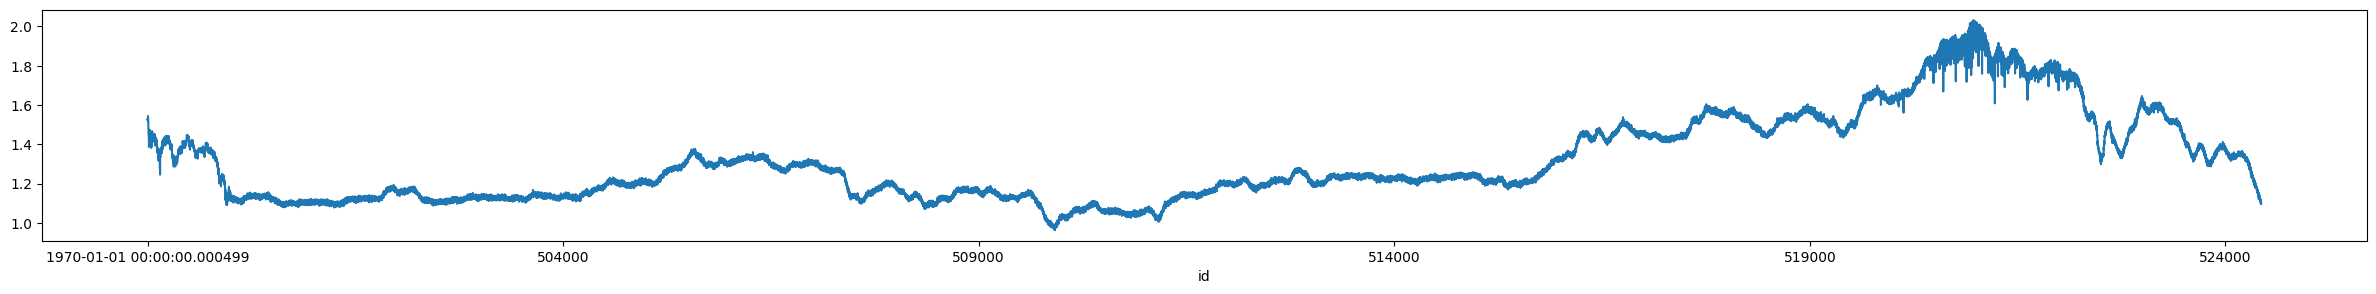

In [ ]:
def add_technical_indicators(df):
    # Простые скользящие средние
    df['SMA_7'] = df['Close'].rolling(window=7).mean()
    df['SMA_14'] = df['Close'].rolling(window=14).mean()

    # Экспоненциальные скользящие средние
    df['EMA_7'] = df['Close'].ewm(span=7, adjust=False).mean()
    df['EMA_14'] = df['Close'].ewm(span=14, adjust=False).mean()

    # RSI (индекс относительной силы)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # MACD
    exp12 = df['Close'].ewm(span=12, adjust=False).mean()
    exp26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp12 - exp26
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Bollinger Bands
    rolling_mean = df['Close'].rolling(window=20).mean()
    rolling_std = df['Close'].rolling(window=20).std()
    df['Upper_Band'] = rolling_mean + (rolling_std * 2)
    df['Lower_Band'] = rolling_mean - (rolling_std * 2)

    return df.dropna()

# Оптимизация данных перед обработкой
def optimize_data_processing(df):
    # Преобразуем индекс в DatetimeIndex, если это еще не сделано
    if not isinstance(df.index, pd.DatetimeIndex):
        df = df.copy()
        df.index = pd.to_datetime(df.index)  # Убедимся, что индекс — это время

    # Оптимизация типов данных
    float_cols = df.select_dtypes(include=['float64']).columns
    df.loc[:, float_cols] = df[float_cols].astype('float32')

    # Удаление дубликатов
    df = df[~df.index.duplicated(keep='last')]

    # Интерполяция пропущенных значений
    df = df.interpolate(method='time')  # Теперь индекс должен быть корректным

    return df

tXY = add_technical_indicators(tXY)
tXY = optimize_data_processing(tXY)

# Нормализация данных с оптимизацией
scaler = StandardScaler()
cols_to_scale = [col for col in tXY.columns if col != 'Close']
tXY.loc[:, cols_to_scale] = scaler.fit_transform(tXY[cols_to_scale])

# Оптимизированное создание последовательностей
K, (N, p), Nx, Ny = 80, tXY.shape, 15000, len(pY)  # Уменьшены параметры для экономии памяти
LtX, LtY = [], []

for i in range(N-Ny-K, N-Ny):
    window = tXY.iloc[(i-Nx):i, :].values

    # Добавляем оптимизированные разностные признаки
    diff_features = np.diff(window[:, :4], axis=0, prepend=0)
    window = np.hstack([window, diff_features])

    # Используем относительные изменения цены как цель
    last_price = tXY.iloc[i-1]['Close']
    future_prices = tXY.iloc[i:(i+Ny), tXY.columns.get_loc('Close')].values
    relative_changes = (future_prices - last_price) / last_price

    LtX.append(window)
    LtY.append(relative_changes)

taX, taY = np.array(LtX, dtype='float32'), np.array(LtY, dtype='float32')

# Оптимизированная модель с экономией памяти
class MemoryEfficientLSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=128, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.1)
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
        self.output = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )

    def forward(self, x):
        x, _ = torch.utils.checkpoint.checkpoint(self.lstm, x)  # Gradient checkpointing
        attn_weights = torch.softmax(self.attention(x), dim=1)
        context = (attn_weights * x).sum(dim=1)
        return self.output(context)

# Инициализация модели с mixed precision
model = MemoryEfficientLSTM(taX.shape[2], Ny).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
criterion = nn.HuberLoss()
scaler = torch.cuda.amp.GradScaler()

# Оптимизированный DataLoader
ds = TensorDataset(torch.tensor(taX), torch.tensor(taY))
train_ds, val_ds = random_split(ds, [0.9, 0.1])
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=16, pin_memory=True)

# Обучение с оптимизацией памяти
for epoch in range(30):
    model.train()
    for X, Y in train_dl:
        with torch.cuda.amp.autocast():
            pred = model(X.to(device))
            loss = criterion(pred, Y.to(device))

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
        torch.cuda.empty_cache()

# Прогнозирование с восстановлением абсолютных цен
model.eval()
with torch.no_grad(), torch.cuda.amp.autocast():
    last_price = tXY.iloc[-1]['Close']
    window = tXY.iloc[-Nx:].values
    diff_features = np.diff(window[:, :4], axis=0, prepend=0)
    window = np.hstack([window, diff_features])
    changes = model(torch.tensor(window[np.newaxis], dtype=torch.float32).to(device))
    predicted_prices = last_price * (1 + changes.cpu().numpy().reshape(-1))
    pY['Close'] = predicted_prices

# Визуализация и сохранение
ax = pd.concat([tXY.iloc[-1000:].Close, pY.Close]).plot(figsize=(30,3))
ToCSV(pY, 'Crypto-optimized')

1. The model generates a baseline submission CSV file, see Colab folder (🗀 on the left).
1. You can download the generated CSV file and submit it to Kaggle.

# **References:**

1. Remember to cite your sources here as well! At the least, your textbook should be cited. Google Scholar allows you to effortlessly copy/paste an APA citation format for books and publications. Also cite StackOverflow, package documentation, and other meaningful internet resources to help your peers learn from these (and to avoid plagiarism claims).

<font size=5>⌛</font> <strong><font color=orange size=5>Do not exceed competition's runtime limit!</font></strong>

<hr color=red>


In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

# 💡**Starter Ideas**

1. Try different RNN architectures and hyperparameters
1. Try [correlation loss/metric](https://duckduckgo.com/?q=correlation+loss+in+tensorflow&ia=web) (or equivalent)
1. Try longer/shorter history. FYI: GPU may not fit all observations, but you could lower the precision or simplify DNN
1. Try forecasting returns (differences or log differences at different lags) instead of actual values. Returns might appear "more" stationary (You'll need to compute forecasted prices from forecasted returns later)
1. Try new features: differences, fractions, powers of existing features, lagged features or lagged differences,..
1. Try a different time scale. Eg. forecasting every $k$ steps and then imputing interim values
1. Try technique in HOML pp.509-510
1. Try (programmatically) assigning higher/lower weights to history or historical events (such as extreme events)
1. Check [Kaggle G-Research Crypto Forecasting](https://www.kaggle.com/c/g-research-crypto-forecasting/code) competition for more suitable ideas.
1. Try further smoothing/averaging and forecasting values at sparser intervals
1. Try forecasting just the future trend